In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from catboost import CatBoostClassifier


import random
import re
from collections import Counter
import gensim.downloader as api
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer



In [2]:
!pip install psycopg2
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for psycopg2: filename=psycopg2-2.9.9-cp310-cp310-linux_x86_64.whl size=166837 sha256=f29f7bc387bae8dc4812bd9df783218817c77761b034c3c728945b9e268b4727
  Stored in directory: /root/.cache/pip/wheels/7d/75/13/da1c6d88687ae81bf5e3cfa07d702981ba137963163472b050
Successfully built psycopg2


# Загрузка данных

In [3]:
def execute_pd(q):
    df = pd.read_sql(
    q,
    con="some_data"
    )
    return df

In [49]:
q = """SELECT * FROM "user_data" """
user_data = execute_pd(q)
user_data.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [50]:
q = """SELECT * FROM post_text_df """
post_text = execute_pd(q)
post_text.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [51]:
q = """SELECT  * from feed_data WHERE action='view' limit 1000000"""
feed_data = execute_pd(q)
feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-02 11:05:35,103083,3688,view,0
1,2021-11-02 11:07:12,103083,1796,view,0
2,2021-11-02 11:08:48,103083,3256,view,0
3,2021-11-04 15:25:04,103083,5363,view,0
4,2021-11-04 15:27:39,103083,2931,view,1


In [52]:
#or
#feed_data = pd.read_csv('./feed_data.csv')
#user_data = pd.read_csv('./user_data.csv')
#post_text = pd.read_csv('./post_text.csv')

# Предобработка данных

In [53]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


In [54]:
user_data.isna().sum()

user_id      0
gender       0
age          0
country      0
city         0
exp_group    0
os           0
source       0
dtype: int64

In [55]:
feed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1000000 non-null  datetime64[ns]
 1   user_id    1000000 non-null  int64         
 2   post_id    1000000 non-null  int64         
 3   action     1000000 non-null  object        
 4   target     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 38.1+ MB


In [56]:
feed_data.isna().sum()

timestamp    0
user_id      0
post_id      0
action       0
target       0
dtype: int64

In [57]:
post_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  7023 non-null   int64 
 1   text     7023 non-null   object
 2   topic    7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


In [58]:
post_text.isna().sum()

post_id    0
text       0
topic      0
dtype: int64

В исходных данных нет пропущенных значений и все типы данных опеределены верно.

# Разведочный анализ данных и построение признаков

Сначала обработаем таблицу post_text, выделим признаки из текста. 

In [9]:
# Предобработка текста
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

#Удаление стоп-слов
def remove_stopwords(tokens):
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

#Стемминг
def perform_stemming(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [10]:
# Предобработка
post_text["text"] = post_text["text"].apply(preprocess_text)

#Токенизация
post_text["text"] = post_text["text"].apply(word_tokenize)

#Удаление стоп-слов
post_text["text"] = post_text["text"].apply(remove_stopwords)

#Стемминг
post_text["text"] = post_text["text"].apply(perform_stemming)


In [11]:
post_text["text"] = post_text["text"].apply(lambda tokens: " ".join(tokens))

In [12]:
post_text.head()

,post_id,text,topic
0,1,uk economi face major risk uk manufactur secto...,business
1,2,aid climat top davo agenda climat chang fight ...,business
2,3,asian quak hit european share share europ lead...,business
3,4,india power share jump debut share india large...,business
4,5,lacroix label bought us firm luxuri good group...,business


### TF-IDF

In [13]:
tfidf = TfidfVectorizer()
tfidf.fit(post_text['text'])

TfidfVectorizer()

Поверх множественного признака - вектора TF-IDF применим аггрегацию: 
- среднее (оценим насколько в тексте поста все слова важны, насколько они "яркие")
- максимум (как некоторую оценку самого важного слова в тексте поста)

In [14]:
post_text['TF_IDF_max'] = post_text['text'].apply(lambda x: tfidf.transform([x]).todense().max())
post_text['TF_IDF_mean'] = post_text['text'].apply(lambda x: tfidf.transform([x]).todense().mean())
post_text.head(2)

,post_id,text,topic,TF_IDF_max,TF_IDF_mean
0,1,uk economi face major risk uk manufactur secto...,business,0.496292,0.000195
1,2,aid climat top davo agenda climat chang fight ...,business,0.251512,0.000274


### FASTTEXT

In [15]:
import gensim.downloader as api

fasttext = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [16]:
import string
from collections import Counter


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        #Чистка текста
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)
        
        #Выбием слова с частотой >= минимальной
        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>') # токен для слов, которых нет в словаре
        
        #словарь для перевода индекса в слово
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        
        #Словарь для перевода слова в индекс
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    #Получить слово по индексу
    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    #Получить индекс по слову
    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]
    
    #Функция, позволяющая закодировать текст
    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    #Функция построения вектора эмбединнгов
    def build_vectors(self, fasttext):
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [17]:
#Строим словарь
vocab = Vocabulary(post_text['text'], min_freq=5)

In [18]:
#из текста делаем longtensor, т.к нам нужны целочисленные значения (индексы)
#применим аггрегацию эмбеддингов: среднее и минимум
post_text['emb_min'] = post_text['text'].apply(lambda x: torch.LongTensor(vocab.encode(x)).numpy().min())
post_text['emb_mean'] = post_text['text'].apply(lambda x: torch.LongTensor(vocab.encode(x)).numpy().mean())
post_text.head(2)

,post_id,text,topic,TF_IDF_max,TF_IDF_mean,emb_min,emb_mean
0,1,uk economi face major risk uk manufactur secto...,business,0.496292,0.000195,117,5818.236842
1,2,aid climat top davo agenda climat chang fight ...,business,0.251512,0.000274,70,5728.884000


### Обработка даты/времни

In [19]:
#Переведем колонку timestamp в формат datetime
feed_data['timestamp'] = pd.to_datetime(feed_data['timestamp'])

#Выделим признаки: день недели, час, месяц
feed_data['day_of_week'] = feed_data.timestamp.dt.dayofweek
feed_data['hour'] = feed_data.timestamp.dt.hour
feed_data['month'] = feed_data.timestamp.dt.month

Исследуем влияние временных признаков на целевую переменную

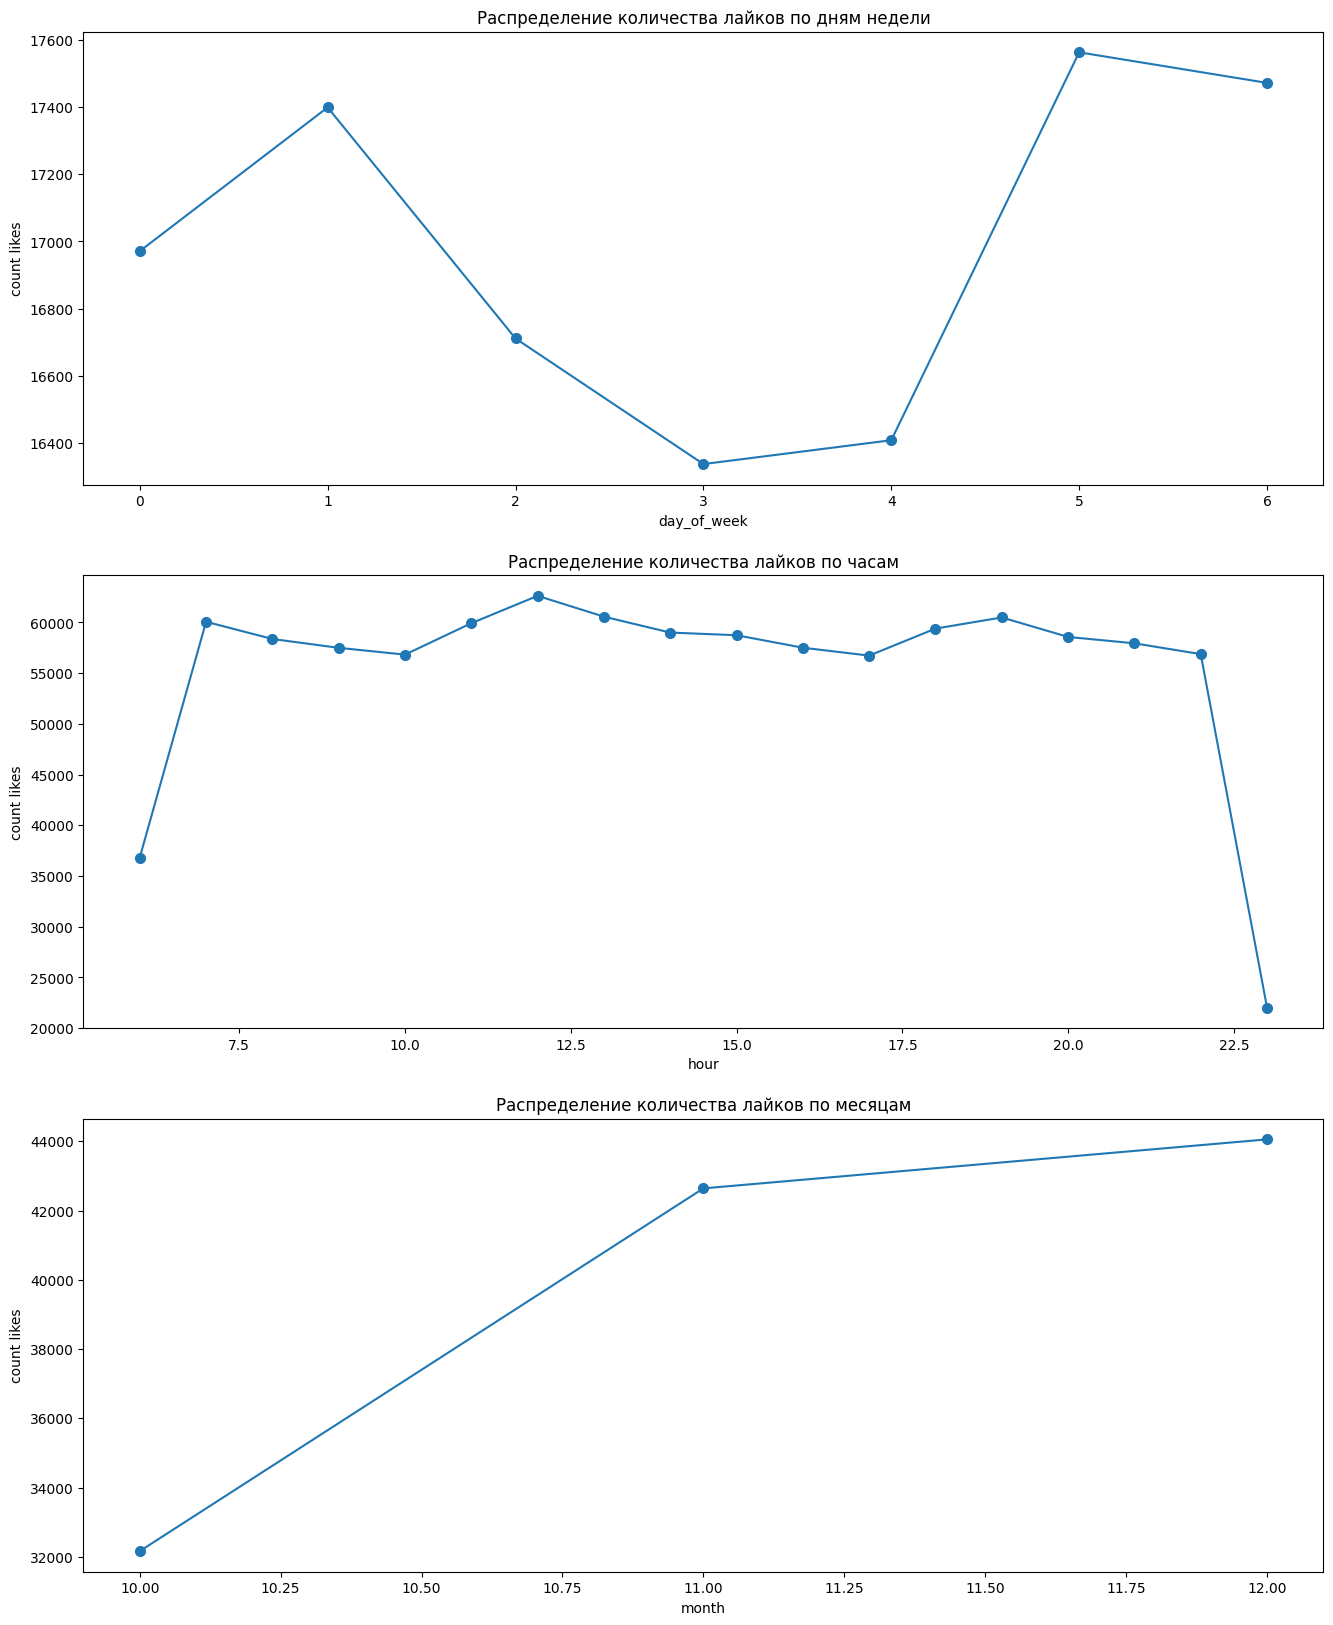

In [20]:
fig = plt.figure()
fig.set_size_inches(16, 20)

ax_1 = fig.add_subplot(3, 1, 1)
plt.title('Распределение количества лайков по дням недели')
plt.xlabel('day_of_week')
plt.ylabel('count likes')
plt.plot(sorted(list(feed_data['day_of_week'].unique())), 
    feed_data[feed_data['target']== 1].groupby(['day_of_week'], as_index=False)['target'].count()['target'],
     marker='o', markersize=7)



ax_2 = fig.add_subplot(3, 1, 2)
plt.title('Распределение количества лайков по часам')
plt.xlabel('hour')
plt.ylabel('count likes')
plt.plot(sorted(list(feed_data['hour'].unique())), 
    feed_data.groupby(['hour'], as_index=False)['target'].count()['target'],
      marker='o', markersize=7)

ax_3 = fig.add_subplot(3, 1, 3)
plt.title('Распределение количества лайков по месяцам')
plt.xlabel('month')
plt.ylabel('count likes')
plt.plot(sorted(list(feed_data['month'].unique())), 
    feed_data[feed_data['target']== 1].groupby(['month'], as_index=False)['target'].count()['target'],
      marker='o', markersize=7)

plt.show()

Во всех новых временных признаках наблюдается некоторое различное распределение таргета, можно сделать вывод, что эти признаки нам важны. 

In [35]:
#смержим все данные
df = pd.merge(post_text, feed_data, on='post_id')
df = pd.merge(user_data, df, on='user_id')
df.head()

,user_id,gender,age,country,city,exp_group,os,source,post_id,text,...,TF_IDF_max,TF_IDF_mean,emb_min,emb_mean,timestamp,action,target,day_of_week,hour,month
0,10608,1,20,Russia,Glazov,2,Android,ads,18,parmalat founder offer apolog founder former b...,...,0.635874,0.000183,32,5640.423645,2021-12-20 08:39:17,view,0,0,8,12
1,10608,1,20,Russia,Glazov,2,Android,ads,23,christma shopper flock till shop uk report str...,...,0.340573,0.000187,70,6193.724490,2021-12-20 08:50:46,view,0,0,8,12
2,10608,1,20,Russia,Glazov,2,Android,ads,2373,sdward wont stop laugh prick end covid httpstc...,...,0.529001,0.000058,221,6870.500000,2021-11-23 11:13:22,view,0,1,11,11
3,10608,1,20,Russia,Glazov,2,Android,ads,34,five million german work germani unemploy figu...,...,0.354658,0.000208,48,5375.237805,2021-11-13 06:31:49,view,0,5,6,11
4,10608,1,20,Russia,Glazov,2,Android,ads,37,bush budget seek deep cutback presid bush pres...,...,0.378307,0.000245,7,6288.181818,2021-11-21 13:03:56,view,0,6,13,11


In [36]:
df.shape

(1000000, 21)

# Разделение на тестовую и обучающую выборки

In [37]:
df = df.sort_values("timestamp")
X = df.drop(['user_id', 'post_id', 'timestamp', 'action', 'target', 'text'], axis=1)
y = df['target']

In [61]:
#проверим сбалансированность классов таргета
y.value_counts()

target
0    881139
1    118861
Name: count, dtype: int64

классы несбалансированы, поэтому при построении модели будем использовать утилиту class_weight

In [38]:
#Разделим выборку на тренировочную и тестовую. 
#Т.к это временной ряд, используем разделение упорядоченной выборки

n = int(df.shape[0]*0.2)
X_train = X.iloc[:-n].copy()
X_test = X.iloc[-n:].copy()

y_train = y.iloc[:-n].copy()
y_test = y.iloc[-n:].copy()

In [40]:
X.columns

Index(['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source',
       'topic', 'TF_IDF_max', 'TF_IDF_mean', 'emb_min', 'emb_mean',
       'day_of_week', 'hour', 'month'],
      dtype='object')

# Обучение модели классификации

In [41]:
#Определим категориальные переменные
cat_features = ['gender', 'country', 'city', 'exp_group', 'os', 'source', 'topic', 'day_of_week', 'hour', 'month']


In [62]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)


In [63]:
catboost_model = CatBoostClassifier(class_weights = class_weight, cat_features=cat_features, silent=True, eval_metric='F1')
catboost_model.fit(X_train, y_train)

## Оценка модели

In [64]:
y_pred = catboost_model.predict(X_test)

In [65]:
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

ROC AUC: 0.6118654719245634
              precision    recall  f1-score   support

           0       0.92      0.47      0.62    172556
           1       0.18      0.75      0.30     27444

    accuracy                           0.51    200000
   macro avg       0.55      0.61      0.46    200000
weighted avg       0.82      0.51      0.58    200000



In [66]:
#Посмотрим оценку важности признаков
pd.DataFrame(catboost_model.feature_importances_, X.columns, columns = ["Features"]).sort_values(by = "Features", ascending = False)

,Features
age,17.766686
emb_min,11.748128
TF_IDF_max,11.020966
city,10.844401
TF_IDF_mean,10.758101
emb_mean,10.075570
topic,9.049990
exp_group,4.939149
hour,4.543839
month,3.271386


Сохранение модели

In [ ]:
catboost_model.save_model('catboost_model',
                           format="cbm")

In [67]:
#Подготовим данные для работы будущего сервиса
upload_data = pd.merge(user_data.reset_index(), post_text.drop(['text'], axis=1).reset_index(), how='outer').drop('index', axis=1)
upload_data

,user_id,gender,age,country,city,exp_group,os,source,post_id,topic
0,200,1,34,Russia,Degtyarsk,3,Android,ads,1.0,business
1,201,0,37,Russia,Abakan,0,Android,ads,2.0,business
2,202,1,17,Russia,Smolensk,4,Android,ads,3.0,business
3,203,0,18,Russia,Moscow,1,iOS,ads,4.0,business
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,5.0,business
...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,NaN,NaN
163201,168549,0,18,Russia,Tula,2,Android,organic,NaN,NaN
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,NaN,NaN
163203,168551,0,38,Russia,Moscow,3,iOS,organic,NaN,NaN


In [ ]:
from sqlalchemy import create_engine

engine = create_engine(
    "some_data"
)

In [69]:
# записываем таблицу 
upload_data.to_sql('lyudmila_anoshkina_features', con=engine, if_exists='replace', index=False) 

#or
#upload_data.to_csv('lyudmila_anoshkina_features.csv')